In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

In [3]:
TSLA = yf.Ticker('TSLA')
df = TSLA.history(start = "2001-01-02")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-14 00:00:00-04:00,183.949997,186.279999,182.009995,185.000000,96306500,0.0,0.0
2023-04-17 00:00:00-04:00,186.320007,189.690002,182.690002,187.039993,116662200,0.0,0.0
2023-04-18 00:00:00-04:00,187.149994,187.690002,183.580002,184.309998,92067000,0.0,0.0


In [4]:
# Drop Unecessary Columns
df.drop(['Dividends','Stock Splits'],axis=1)

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500
...,...,...,...,...,...
2023-04-14 00:00:00-04:00,183.949997,186.279999,182.009995,185.000000,96306500
2023-04-17 00:00:00-04:00,186.320007,189.690002,182.690002,187.039993,116662200
2023-04-18 00:00:00-04:00,187.149994,187.690002,183.580002,184.309998,92067000


Data Exploration

In [5]:
# Summary Statistics
df.describe().drop(['Dividends','Stock Splits'],axis=1)

,Open,High,Low,Close,Volume
count,3225.000000,3225.000000,3225.000000,3225.000000,3.225000e+03
mean,61.572140,62.963149,60.047860,61.536397,9.531073e+07
std,96.263513,98.483590,93.770954,96.152015,8.172756e+07
min,1.076000,1.108667,0.998667,1.053333,1.777500e+06
25%,9.458667,9.662667,9.235333,9.466667,4.343850e+07
50%,16.476667,16.706667,16.242666,16.476000,7.731150e+07
75%,35.317333,36.197334,33.543999,34.990665,1.209630e+08
max,411.470001,414.496674,405.666656,409.970001,9.140820e+08


Text(0.5, 1.0, 'Tesla Stock Price 2010-06-29 - 2023-04-19')

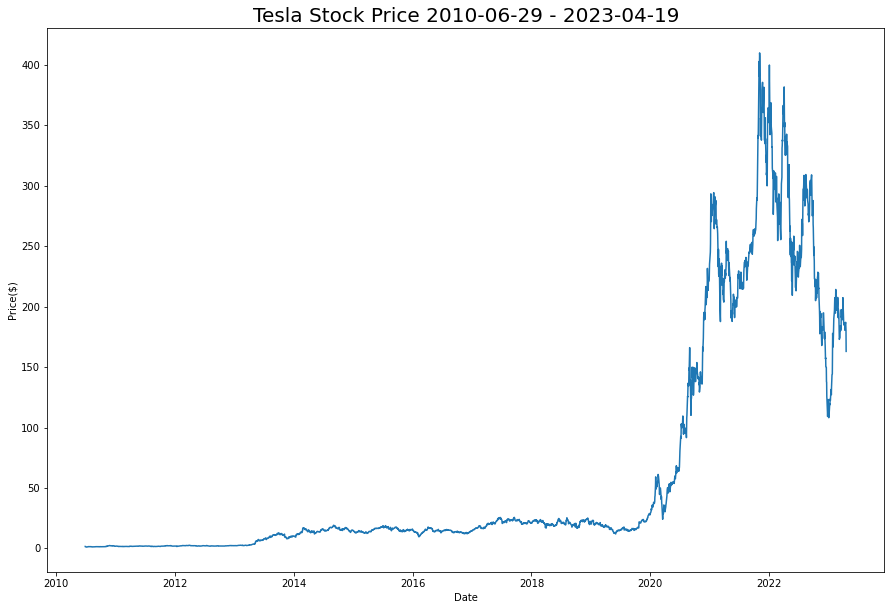

In [6]:
# Close Price Movement
plt.figure(figsize =(15,10))
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Price($)')
plt.title('Tesla Stock Price 2010-06-29 - 2023-04-19', fontsize =20)

Text(0.5, 1.0, 'Tesla Daily Return (%)  2010-06-29 - 2023-04-19')

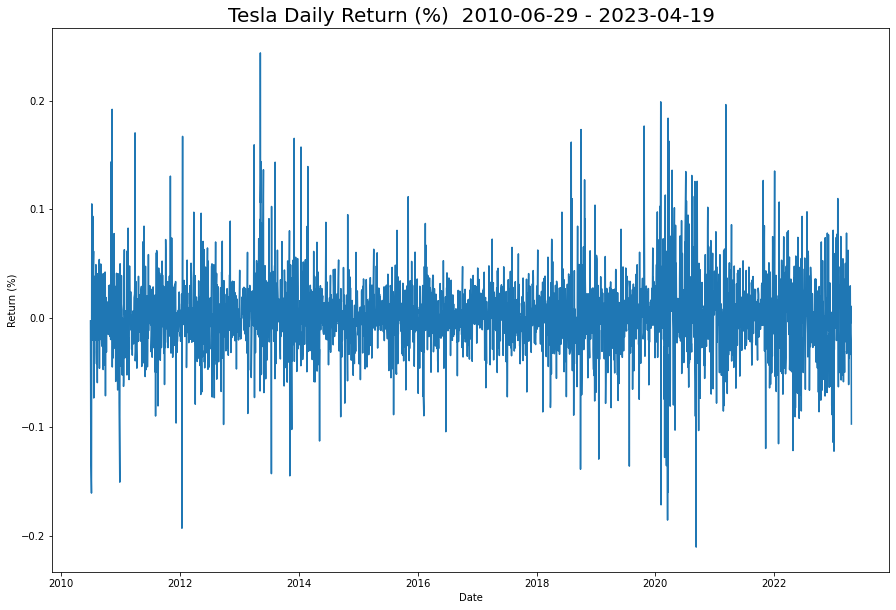

In [7]:
# Daily Return
new_df = pd.DataFrame()
new_df['return'] = ((df['Close']-df['Close'].shift(1))/df['Close'].shift(1))
plt.figure(figsize =(15,10))
plt.plot(new_df['return'])
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.title('Tesla Daily Return (%)  2010-06-29 - 2023-04-19', fontsize =20)

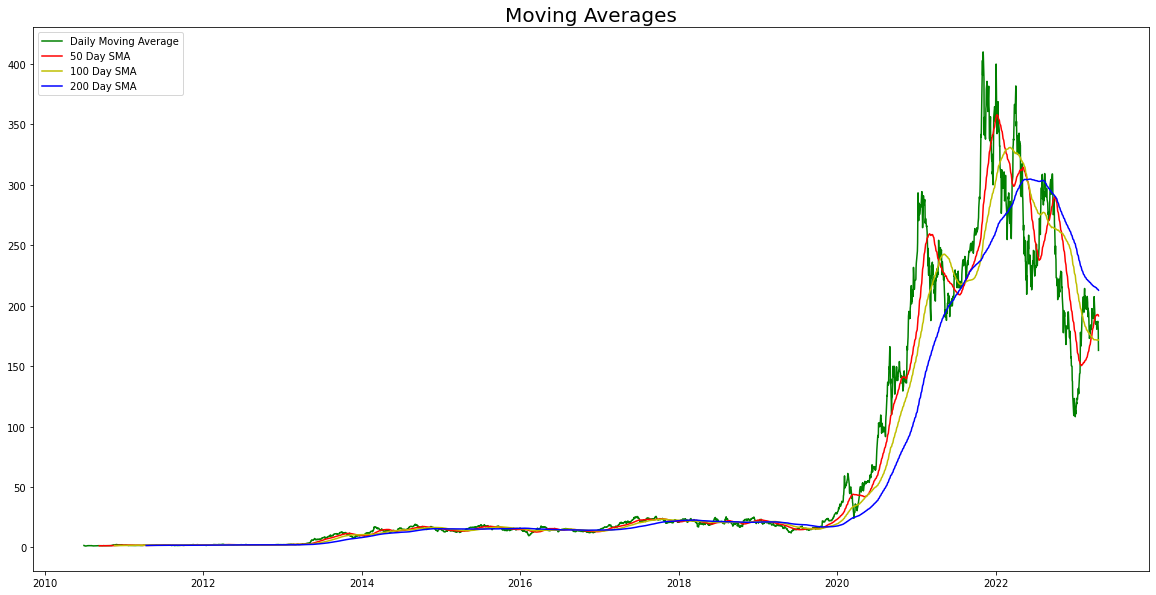

In [8]:
# Simply Moving Average

SMA = pd.DataFrame()

SMA['Daily'] = df['Close']
SMA['50 Day SMA'] = df['Close'].rolling(window = 50).mean()
SMA['100 Day SMA'] = df['Close'].rolling(window = 100).mean()
SMA['200 Day SMA'] = df['Close'].rolling(window = 200).mean()

plt.figure(figsize=(20,10))
plt.plot(SMA['Daily'],'g-', label ='Daily Moving Average')
plt.plot(SMA['50 Day SMA'],'r-', label = '50 Day SMA')
plt.plot(SMA['100 Day SMA'], 'y-', label = '100 Day SMA')
plt.plot(SMA['200 Day SMA'], 'b-', label = '200 Day SMA')

plt.title("Moving Averages", fontsize = 20)
plt.legend()



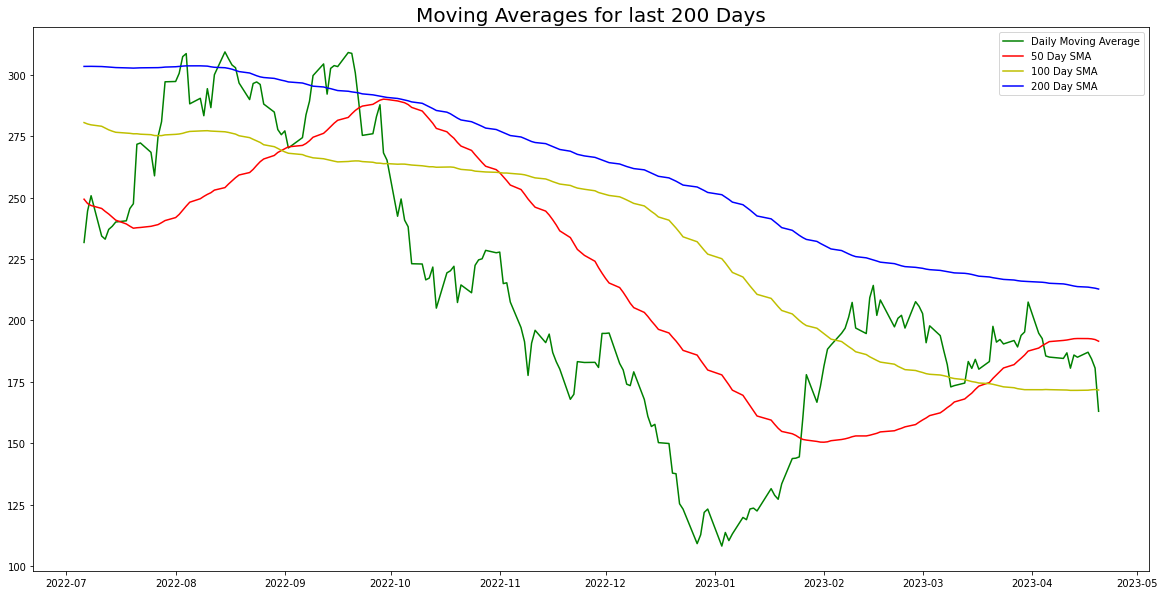

In [9]:
# SMA of Last 200 Trading Days

plt.figure(figsize=(20,10))
plt.plot(SMA['Daily'].iloc[-200:],'g-', label ='Daily Moving Average')
plt.plot(SMA['50 Day SMA'].iloc[-200:],'r-', label = '50 Day SMA')
plt.plot(SMA['100 Day SMA'].iloc[-200:], 'y-', label = '100 Day SMA')
plt.plot(SMA['200 Day SMA'].iloc[-200:], 'b-', label = '200 Day SMA')

plt.title("Moving Averages for last 200 Days", fontsize = 20)
plt.legend()

Preparing the Data

Train, Test, Validate

In [10]:
# Splitting the Data into Train, Test, and Validate Sets
    # Note that stock price data is temporal, as such we want to split our data such that it is ordered as training, testing and validation, respectively. 
    # This is because the past stock price helps predict the following stock price


# Will split the data as following: Train (60%) , Test(20%), Validate (20%)

features = df.drop(['Close'],axis=1)
target = df['Close']

train_split = int(0.6 * len(df))
val_split = int(0.8 * len(df))

In [11]:
# Training Set
X_train = features.iloc[:train_split, :-1]
y_train = target.iloc[:train_split]

# Check size
X_train.shape

(1935, 5)

In [12]:
# Testing Set
X_test = features.iloc[train_split:val_split, :-1]
y_test = target.iloc[train_split:val_split]

# Check size
X_test.shape
y_test

Date
2018-03-07 00:00:00-05:00     22.153334
2018-03-08 00:00:00-05:00     21.940001
2018-03-09 00:00:00-05:00     21.811333
2018-03-12 00:00:00-04:00     23.034000
2018-03-13 00:00:00-04:00     22.789333
                                ...    
2020-09-21 00:00:00-04:00    149.796661
2020-09-22 00:00:00-04:00    141.410004
2020-09-23 00:00:00-04:00    126.786667
2020-09-24 00:00:00-04:00    129.263336
2020-09-25 00:00:00-04:00    135.779999
Name: Close, Length: 645, dtype: float64

In [13]:
# Validation Set
X_val = features.iloc[val_split:, :-1]
y_val = target.iloc[val_split:]

# Check size
X_val.shape

(645, 5)

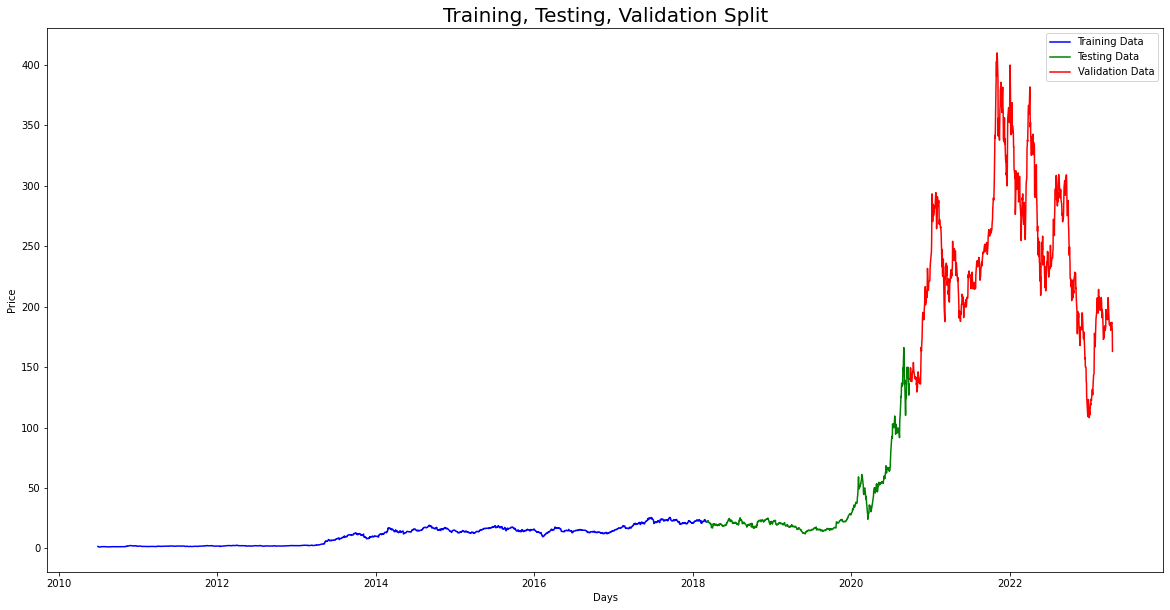

In [14]:
Training = range(len(y_train))
Test = range(len(y_train), len(y_train) + len(y_test))
Validation = range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val))

# Plot the data
plt.figure(figsize=(20,10))
plt.plot(df.index[Training], y_train, 'b-', label='Training Data')
plt.plot(df.index[Test], y_test, 'g-', label='Testing Data')
plt.plot(df.index[Validation], y_val, 'r-', label='Validation Data')


plt.title("Training, Testing, Validation Split", fontsize=20)
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()


In [74]:
# Normalizing the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1,1))


# Calculate the mean and standard deviation for each feature
mu_test_list = np.mean(X_test_scaled, axis=0)
std_test_list = np.std(X_test_scaled, axis=0)

Training the Model

In [1]:
import math
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_test_scaled, \
                          y_test, \
                          mu_test_list, \
                          std_test_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, 
                   return_sequences=True, 
                   input_shape=(x_train_scaled.shape[1],1)))
    # Add dropput with a probability of 0.5
    model.add(Dropout(dropout_prob)) 
    model.add(LSTM(units=lstm_units))
    # Add dropput with a probability of 0.5
    model.add(Dropout(dropout_prob)) 
    model.add(Dense(1))
    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs,   
              batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_test_scaled)
    est = (est_scaled * std_test_list) + mu_test_list
    
    # Calculate RMSE and MAPE
    #rmse = math.sqrt(mean_squared_error(y_test, est))
    #mape = get_mape(y_test, est)
    
    return est, y_test

In [ ]:
train_pred_eval_model(X_train_scaled,y_train_scaled,)